In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Introducing the Keras Sequential API**

**Learning Objectives**
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to use feature columns in a Keras model
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy and make predictions with at Keras model

## **Introduction**

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

In this lab, we'll see how to build a simple deep neural network model using the Keras sequential api and feature columns. Once we have trained our model, we will deploy it using AI Platform and see how to call our model for online prediciton.

In [3]:
# The datetime module used to work with dates as date objects.
import datetime
# The OS module in python provides functions for interacting with the operating system.
import os
# The shutil module in Python provides many functions of high-level operations on files and collections of files.
# This module helps in automating process of copying and removal of files and directories.
import shutil

# Here we'll import data processing libraries like Numpy, Pandas and Tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf

# Import pyplot package from matplotlib library
from matplotlib import pyplot as plt
# Import keras package from tensorflow library
from tensorflow import keras

# Import Sequential function from tensorflow.keras.models
from tensorflow.keras.models import Sequential
# Import Dense, DenseFeatures function from tensorflow.keras.layers
from tensorflow.keras.layers import Dense, DenseFeatures
# Import TensorBoard function from tensorflow.keras.callbacks
from tensorflow.keras.callbacks import TensorBoard

# Here we'll show the currently installed version of TensorFlow
print(tf.__version__)
%matplotlib inline

2.3.0


## **Load raw data**

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence.

## **Use tf.data to read the CSV files**

We wrote these functions for reading data from the csv files above in the previous notebook.

In [4]:
# Defining the feature names into a list `CSV_COLUMNS`
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
# Defining the default values into a list `DEFAULTS`
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


def features_and_labels(row_data):
# The .pop() method will return item and drop from frame. 
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode='eval'):
# The tf.data.experimental.make_csv_dataset() method reads CSV files into a dataset
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

# The map() function executes a specified function for each item in an iterable.
# The item is sent to the function as a parameter.
    dataset = dataset.map(features_and_labels)

    if mode == 'train':
# The shuffle() method takes a sequence (list, string, or tuple) and reorganize the order of the items.
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## **Build a simple keras DNN model**

We will use feature columns to connect our raw data to our keras DNN model. Feature columns make it easy to perform common types of feature engineering on your raw data. For example, you can one-hot encode categorical data, create feature crosses, embeddings and more. We'll cover these in more detail later in the course, but if you want to a sneak peak browse the official TensorFlow [feature columns guide](https://www.tensorflow.org/guide/feature_columns).

In our case we won't do any feature engineering. However, we still need to create a list of feature columns to specify the numeric values which will be passed on to our model. To do this, we use `tf.feature_column.numeric_column()`

We use a python dictionary comprehension to create the feature columns for our model, which is just an elegant alternative to a for loop.

In [5]:
# Defining the feature names into a list `INPUT_COLS`
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
]

# Create input layer of feature columns
# TODO 1
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
    }

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

In [6]:
# Build a keras DNN model using Sequential API
# TODO 2a
model = Sequential([
    DenseFeatures(feature_columns=feature_columns.values()),
    Dense(units=32, activation="relu", name="h1"),
    Dense(units=8, activation="relu", name="h2"),
    Dense(units=1, activation="linear", name="output")
    ])

Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

We will add an additional custom metric called `rmse` to our list of metrics which will return the root mean square error. 

In [7]:
# TODO 2b
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

## **Train the model**

To train your model, Keras provides three functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.fit_generator()` for training a model on data yielded batch-by-batch by a generator
 3. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works well for small datasets which can fit entirely in memory. However, for large datasets (or if you need to manipulate the training data on the fly via data augmentation, etc) you will need to use `.fit_generator()` instead. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

The taxifare dataset we sampled is small enough to fit in memory, so can we could use `.fit` to train our model. Our `create_dataset` function above generates batches of training examples, so we could also use `.fit_generator`. In fact, when calling `.fit` the method inspects the data, and if it's a generator (as our dataset is) it will invoke automatically `.fit_generator` for training. 

We start by setting up some parameters for our training job and create the data generators for the training and validation data.

We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.

In [8]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='/content/drive/MyDrive/Datasets/taxi-train.csv',
    batch_size=TRAIN_BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    pattern='/content/drive/MyDrive/Datasets/taxi-valid.csv',
    batch_size=1000,
    mode='eval').take(NUM_EVAL_EXAMPLES//1000)

There are various arguments you can set when calling the [.fit method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit). Here `x` specifies the input data which in our case is a `tf.data` dataset returning a tuple of (inputs, targets). The `steps_per_epoch` parameter is used to mark the end of training for a single epoch. Here we are training for NUM_EVALS epochs. Lastly, for the `callback` argument we specify a Tensorboard callback so we can inspect Tensorboard after training. 

In [9]:
%time 
# TODO 3
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
# Train the sequential model
history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(LOGDIR)])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/1 [==============================] - ETA: 0s - loss: 2845.3591 - rmse: 53.3419 - mse: 2845.3591WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'collections.OrderedDict'> input: OrderedDict([('pickup_longitude', <tf.Tensor 'ExpandDims_4:0' shape=(1000, 1) dtype=float32>), ('pickup_latitude', <tf.Tensor 'ExpandDims_3:0' shape=(1000, 1) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'ExpandDims_1:0' shape=(1000, 1) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'ExpandDims:0' shape=(1000, 1) dtype=float32>), ('passenger_count', <tf.Tensor 'ExpandDims_2:0' shape=(1000, 1) dtype=float32>)])
Consider rewriting this model with the Functional API.
1/1 [==============================] - 1s 965ms/step - loss: 2845.3591 - rmse: 53.3419 - mse

### **High-level model evaluation**

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [10]:
# The summary() is a generic function used to produce result summaries of the results of various model fitting functions.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


Running `.fit` (or `.fit_generator`) returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

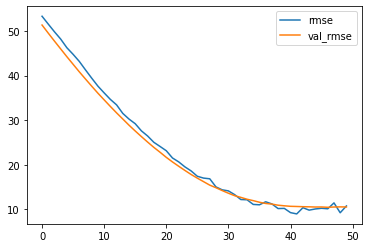

In [11]:
RMSE_COLS = ['rmse', 'val_rmse']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[RMSE_COLS].plot()

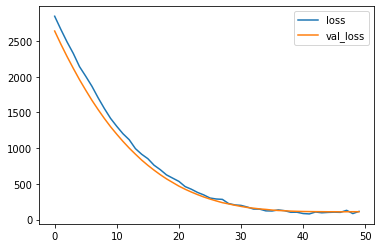

In [12]:
LOSS_COLS = ['loss', 'val_loss']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[LOSS_COLS].plot()

# **Making predictions with our model**

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [13]:
# The predict() method will predict the response for model. 
# Using tf.convert_to_tensor() we will convert the given value to a Tensor. 
model.predict(x={"pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                 "passenger_count": tf.convert_to_tensor([3.0])},
              steps=1)

Consider rewriting this model with the Functional API.


array([[10.869488]], dtype=float32)